## NLP et MongoDB

### Objectifs: 
- Appliquer un traitement NLP sur une base de connaissance.
- Enrichissement des documents MongoDB avec des tags automatiques ou entités nommées.


## Enrichissement de texte avec spaCy et stockage dans MongoDB

In [39]:
#pip install Spacy pymongo pandas

In [40]:
#python -m spacy download fr_core_news_md

In [41]:
#pip install protobuf==3.20.*

In [7]:
import spacy
import pandas as pd
from pymongo import MongoClient
from pprint import pprint
import fr_core_news_md
from collections import defaultdict, Counter
import matplotlib.pyplot as plt


In [8]:

# Chargement du modèle français
nlp = spacy.load("fr_core_news_md")
#nlp = fr_core_news_md.load()
# Connexion MongoDB (localhost ou Atlas)
client = MongoClient("mongodb://localhost:27017")
db = client["tickets_support"]
collection = db["tickets"]


In [23]:
print(client.list_database_names())

['Restaurants_DB', 'admin', 'config', 'estore', 'local', 'sample_airbnb', 'sample_analytics', 'sample_geospatial', 'sample_guides', 'sample_mflix', 'sample_restaurants', 'sample_supplies', 'sample_training', 'sample_weatherdata', 'tickets_support']


In [118]:
# Chargement d’un corpus de tickets clients
tickets = [
    {"id": 1, "texte": "J'ai un problème d'acces à mon espace client depuis que j'ai fait un changement d'adresse à Lyon depuis un mois."},
    {"id": 2, "texte": "L'incident a eu lieu à Nantes hier matin."},
    {"id": 3, "texte": "Merci pour votre assistance rapide ! Le problème est résolu."},
    {"id": 4, "texte": "Je n’arrive pas à me connecter à mon espace client depuis hier."},
    {"id": 5, "texte": "L’application plante depuis le 12 mai 2023 à 14h"},
    {"id": 6, "texte": "Mon contrat avec Orange Business arrive à échéance."},
    {"id": 7, "texte": "Je n’ai pas eu de réponse depuis ma demande du 12 mai 2023 sur ma facture Bouygues à Paris."},
    {"id": 8, "texte": "Merci de transférer mon dossier à Mme Dupont."},
    {"id": 9, "texte": "Le montant de ma dernière facture SFR est incorrect."},
    {"id": 10, "texte": "Je souhaite résilier mon abonnement depuis Paris."},
    {"id": 11, "texte": "La mise à jour du 3 avril a causé des erreurs dans l’application."},
    {"id": 12, "texte": "Peut-on envoyer le duplicata à M. Martin à Paris ?"},
    {"id": 13, "texte": "J’ai changé de carte bancaire le 5 juin et le paiement a échoué."},
    {"id": 14, "texte": "Je n’arrive plus à accéder à mon compte client."},
    {"id": 15, "texte": "Quand vais-je recevoir ma facture du mois de mai ?"},
    {"id": 16, "texte": "Mon service internet est en panne depuis deux jours."},
    {"id": 17, "texte": "Impossible de me connecter à l’espace personnel."},
    {"id": 18, "texte": "L’erreur 403 apparaît à chaque tentative de connexion."},
    {"id": 19, "texte": "Merci de corriger le montant de ma dernière facture."},
    {"id": 20, "texte": "Je veux résilier mon contrat mobile Bouygues."},
    {"id": 21, "texte": "Depuis la mise à jour de l’app, je ne peux plus me connecter."},
    {"id": 22, "texte": "Quel est le délai pour activer mon espace client ?"},
    {"id": 23, "texte": "J’ai perdu l’accès à mon compte après un changement d’adresse."},
    {"id": 24, "texte": "Le service client ne répond pas depuis lundi."},
    {"id": 25, "texte": "Erreur de facturation sur mon abonnement Orange."},
    {"id": 26, "texte": "Pouvez-vous envoyer la nouvelle facture sur mon email ?"},
    {"id": 27, "texte": "Mon compte client est bloqué depuis hier matin."},
    {"id": 28, "texte": "Merci de réinitialiser mon mot de passe pour accéder au service."},
    {"id": 29, "texte": "Je veux accéder à l’historique de mes paiements."}
]

df = pd.DataFrame(tickets)
df


,id,texte
0,1,J'ai un problème d'acces à mon espace client d...
1,2,L'incident a eu lieu à Nantes hier matin.
2,3,Merci pour votre assistance rapide ! Le problè...
3,4,Je n’arrive pas à me connecter à mon espace cl...
4,5,L’application plante depuis le 12 mai 2023 à 14h
5,6,Mon contrat avec Orange Business arrive à éché...
6,7,Je n’ai pas eu de réponse depuis ma demande du...
7,8,Merci de transférer mon dossier à Mme Dupont.
8,9,Le montant de ma dernière facture SFR est inco...
9,10,Je souhaite résilier mon abonnement depuis Tou...


### Traitement NLP avec spaCy

22 mars 2023 → DATE

Lyon → LOC, 1er janvier 2022 → DATE

Mme Dupont → PER

Le rendez-vous est fixé au 10 juillet.	10 juillet → DATE

Orange Business → ORG

hier matin → non détecté → ajouter avec détection manuelle

12 mai → DATE, 14h → TIME (pas toujours détecté en fr)

contact@entreprise.fr → pas reconnu nativement → ajouter via regex personnalisée

Cloud Azure → ORG ou MISC selon le modèle


In [81]:
texte = "Je n’ai pas eu de réponse depuis ma demande du 12 mai 2023 sur ma facture Bouygues à Paris."
#texte ="J'ai un rendez-vous le 15 mai 2024 à Paris avec Orange."
doc = nlp(texte)


# Version 1
print("Entités détectées :")
for ent in doc.ents:
    print(ent.text, ent.label_)


Entités détectées :
Bouygues ORG
Paris LOC


In [82]:
import re

def detect_dates_regex(texte):
    # Exemples simples : 12 mai 2023, 01/01/2022, 1er juin
    pattern = r"\b(\d{1,2}(er)?\s+(janvier|février|mars|avril|mai|juin|juillet|août|septembre|octobre|novembre|décembre)(\s+\d{4})?)\b"
    return re.findall(pattern, texte, re.IGNORECASE)



In [141]:
def analyse_texte(texte):
    doc = nlp(texte)
    # Entités spaCy
    entites = [{"texte": ent.text, "type": ent.label_} for ent in doc.ents]
    
    # Détection complémentaire de dates
    regex_dates = [match[0] for match in detect_dates_regex(texte)]
    for d in regex_dates:
        entites.append({"texte": d, "type": "DATE (regex)"})
    
    # Nettoyage des tokens
    tokens = [token.lemma_ for token in doc if not token.is_stop and not token.is_punct]
    
    #print(tokens)
    #print(entites)
    return {
        "tokens": tokens,
        "entites": entites
    }


In [123]:
# Version 2 
resultat = analyse_texte(texte)

print(resultat)

{'tokens': ['réponse', 'demande', '12', 'mai', '2023', 'facture', 'Bouygues', 'Paris'], 'entites': [{'texte': 'Bouygues', 'type': 'ORG'}, {'texte': 'Paris', 'type': 'LOC'}, {'texte': '12 mai 2023', 'type': 'DATE (regex)'}]}


### Enregistrement des résultats dans MongoDB

In [142]:
# Application à tous les tickets
df["nlp"] = df["texte"].apply(analyse_texte)
df.head()


,id,texte,nlp
0,1,J'ai un problème d'acces à mon espace client d...,"{'tokens': ['problème', 'acce', 'espace', 'cli..."
1,2,L'incident a eu lieu à Nantes hier matin.,"{'tokens': ['incident', 'lieu', 'Nantes', 'hie..."
2,3,Merci pour votre assistance rapide ! Le problè...,"{'tokens': ['assistance', 'rapide', 'problème'..."
3,4,Je n’arrive pas à me connecter à mon espace cl...,"{'tokens': ['arriver', 'connecter', 'espace', ..."
4,5,L’application plante depuis le 12 mai 2023 à 14h,"{'tokens': ['application', 'plant', '12', 'mai..."


### Insertion des données

In [135]:
## 1ere façon de faire
collection.drop()  # pour éviter les doublons

for _, row in df.iterrows():
    document = {
        "ticket_id": row["id"],
        "texte": row["texte"],
        "tokens": row["nlp"]["tokens"],
        "entites": row["nlp"]["entites"]
    }
    collection.insert_one(document)


In [136]:
print("Nombre de documents :", collection.count_documents({}))

Nombre de documents : 29


In [133]:
## 2eme façon de faire
collection.drop()  # pour éviter les doublons

for ticket in tickets:
    nlp_data = analyse_texte(ticket["texte"])
    ticket.update(nlp_data)
    
collection.insert_many(tickets)

In [134]:
print("Nombre de documents :", collection.count_documents({}))

Nombre de documents : 29


In [127]:
print("Les tickets contenant une entité de type Adresse :", collection.count_documents({"entites.type": "LOC"}))


for doc in collection.find({"entites.type": "LOC"}):
    pprint(doc)


Les tickets contenant une entité de type Adresse : 5
{'_id': ObjectId('68247e6bdc70f1fb196d1e53'),
 'entites': [{'texte': 'Lyon', 'type': 'LOC'}],
 'texte': "J'ai un problème d'acces à mon espace client depuis que j'ai fait "
          "un changement d'adresse à Lyon depuis un mois.",
 'ticket_id': 1,
 'tokens': ['problème',
            'acce',
            'espace',
            'client',
            'changement',
            'adresse',
            'Lyon',
            'mois']}
{'_id': ObjectId('68247e6bdc70f1fb196d1e54'),
 'entites': [{'texte': 'Nantes', 'type': 'LOC'}],
 'texte': "L'incident a eu lieu à Nantes hier matin.",
 'ticket_id': 2,
 'tokens': ['incident', 'lieu', 'Nantes', 'hier', 'matin']}
{'_id': ObjectId('68247e6bdc70f1fb196d1e59'),
 'entites': [{'texte': 'Bouygues', 'type': 'ORG'},
             {'texte': 'Paris', 'type': 'LOC'},
             {'texte': '12 mai 2023', 'type': 'DATE (regex)'}],
 'texte': 'Je n’ai pas eu de réponse depuis ma demande du 12 mai 2023 sur ma '
   

In [128]:
print("Les tickets contenant une entité de type DATE :", collection.count_documents({"entites.type":  {"$regex": "DATE"}}))
for doc in collection.find({"entites.type": {"$regex": "DATE"}}):
    pprint(doc)



Les tickets contenant une entité de type DATE : 4
{'_id': ObjectId('68247e6bdc70f1fb196d1e57'),
 'entites': [{'texte': '12 mai 2023', 'type': 'DATE (regex)'}],
 'texte': 'L’application plante depuis le 12 mai 2023 à 14h',
 'ticket_id': 5,
 'tokens': ['application', 'plant', '12', 'mai', '2023', '14h']}
{'_id': ObjectId('68247e6bdc70f1fb196d1e59'),
 'entites': [{'texte': 'Bouygues', 'type': 'ORG'},
             {'texte': 'Paris', 'type': 'LOC'},
             {'texte': '12 mai 2023', 'type': 'DATE (regex)'}],
 'texte': 'Je n’ai pas eu de réponse depuis ma demande du 12 mai 2023 sur ma '
          'facture Bouygues à Paris.',
 'ticket_id': 7,
 'tokens': ['réponse',
            'demande',
            '12',
            'mai',
            '2023',
            'facture',
            'Bouygues',
            'Paris']}
{'_id': ObjectId('68247e6bdc70f1fb196d1e5d'),
 'entites': [{'texte': '3 avril', 'type': 'DATE (regex)'}],
 'texte': 'La mise à jour du 3 avril a causé des erreurs dans l’applicatio

In [143]:
# Enrichissement des tickets
for ticket in tickets:
    nlp_data = analyse_texte(ticket["texte"])
    #print(f"\nTexte: {ticket['texte']}")
    ticket.update(nlp_data)

In [144]:
from collections import Counter

all_tokens = []

# On ne garde que les documents ayant des tokens non vides
for doc in collection.find({"tokens": {"$exists": True, "$ne": []}}):
    cleaned_tokens = [
        token.lower() for token in doc["tokens"]
        if len(token) > 2 and token.isalpha()
    ]
    all_tokens.extend(cleaned_tokens)

# Compter les occurrences des mots
frequents = Counter(all_tokens).most_common(10)

# Affichage plus clair
print("Top 10 mots-clés les plus fréquents :")
for word, count in frequents:
    print(f"- {word} : {count} fois")


Top 10 mots-clés les plus fréquents :
- client : 6 fois
- facture : 5 fois
- espace : 4 fois
- hier : 3 fois
- arriver : 3 fois
- connecter : 3 fois
- mai : 3 fois
- jour : 3 fois
- erreur : 3 fois
- accéder : 3 fois


### Agrégation MongoDB – group by sur entites.type

In [145]:
pipeline = [
    {"$unwind": "$entites"},
    {"$group": {"_id": "$entites.type", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]

results = list(collection.aggregate(pipeline))

print("Nombre d'entités par type :")
for res in results:
    print(f"{res['_id']} : {res['count']}")


Nombre d'entités par type :
LOC : 5
ORG : 5
DATE (regex) : 4
PER : 2
MISC : 2


### Visualisation des tokens les plus fréquents par catégorie

In [151]:
def detect_categorie(texte):
    texte = texte.lower()
    if "facture" in texte or "paiement" in texte:
        return "facturation"
    elif "connexion" in texte or "accès" in texte:
        return "technique"
    elif "orange" in texte or "bouygues" in texte:
        return "opérateur"
    else:
        return "autre"

for doc in collection.find():
    cat = detect_categorie(doc["texte"])
    collection.update_one({"_id": doc["_id"]}, {"$set": {"categorie": cat}})


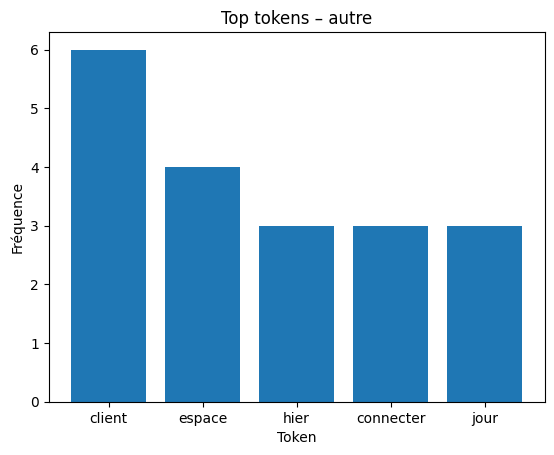

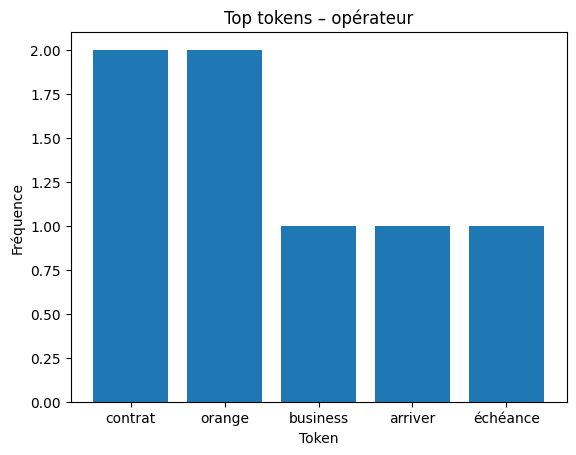

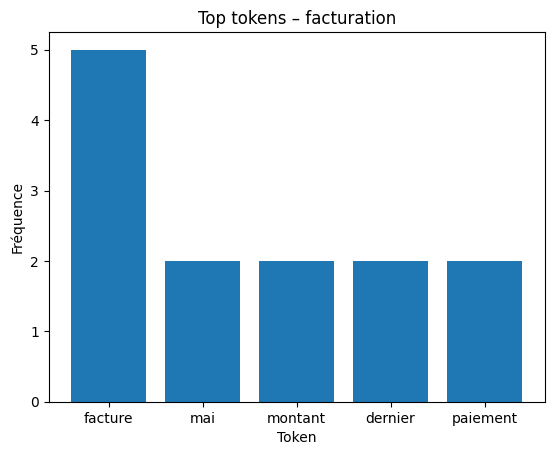

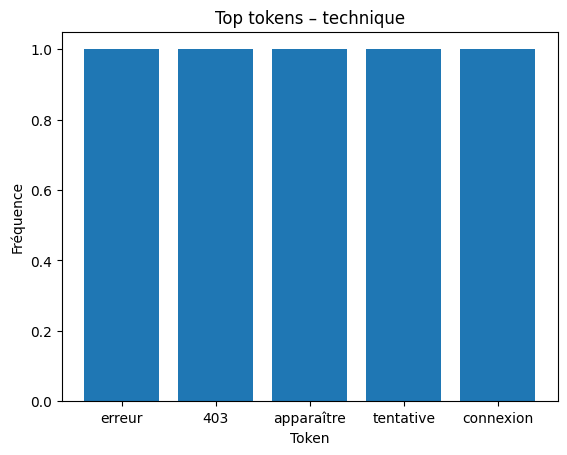

In [152]:
tokens_by_cat = defaultdict(list)

for doc in collection.find({"categorie": {"$exists": True}}):
    for token in doc.get("tokens", []):
        if len(token) > 2:
            tokens_by_cat[doc["categorie"]].append(token.lower())


for cat, tokens in tokens_by_cat.items():
    top = Counter(tokens).most_common(5)
    labels, values = zip(*top)
    
    plt.figure()
    plt.bar(labels, values)
    plt.title(f"Top tokens – {cat}")
    plt.xlabel("Token")
    plt.ylabel("Fréquence")
    plt.show()


### Nuage de mots-clés (WordCloud)

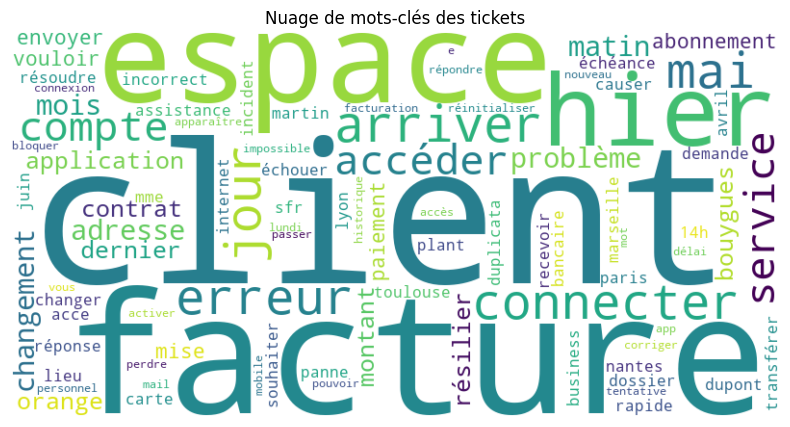

In [148]:
from wordcloud import WordCloud

all_tokens = []

for doc in collection.find():
    all_tokens.extend(token.lower() for token in doc.get("tokens", []) if len(token) > 2)

wordcloud = WordCloud(width=800, height=400, background_color="white").generate(" ".join(all_tokens))

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Nuage de mots-clés des tickets")
plt.show()


### Top des entités par type (PER, ORG, etc.)

In [150]:
from collections import defaultdict

entite_stats = defaultdict(list)

for doc in collection.find():
    for ent in doc.get("entites", []):
        entite_stats[ent["type"]].append(ent["texte"])

# Top 5 par type
for ent_type, textes in entite_stats.items():
    top = Counter(textes).most_common(5)
    print(f"\nTop entités pour {ent_type} :")
    for txt, count in top:
        print(f"  - {txt} : {count}")



Top entités pour LOC :
  - Lyon : 1
  - Nantes : 1
  - Paris : 1
  - Toulouse : 1
  - Marseille : 1

Top entités pour DATE (regex) :
  - 12 mai 2023 : 2
  - 3 avril : 1
  - 5 juin : 1

Top entités pour ORG :
  - Bouygues : 2
  - Orange Business : 1
  - SFR : 1
  - Orange : 1

Top entités pour PER :
  - Mme Dupont : 1
  - M. Martin : 1

Top entités pour MISC :
  - app : 1
  - Erreur : 1


##  Extraction d'informations avec Hugging Face

In [154]:
#pip install transformers torch

In [ ]:
from transformers import pipeline

### Chargement d’un modèle pour la reconnaissance d’entités (NER)

In [1]:
from transformers import pipeline

# Crée un pipeline pour la reconnaissance d'entités nommées en français
ner = pipeline("ner", model="Jean-Baptiste/camembert-ner", aggregation_strategy="simple")

text = "Bienvenue chez Orange ! Pour contacter le service client, appelez le 3900 du lundi au samedi."
results = ner(text)

# Affiche les entités détectées
for r in results:
    print(f"{r['word']} ({r['entity_group']}) - score: {r['score']:.2f}")


config.json:   0%|          | 0.00/892 [00:00<?, ?B/s]

C:\Users\manel\miniconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\manel\.cache\huggingface\hub\models--Jean-Baptiste--camembert-ner. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/269 [00:00<?, ?B/s]

sentencepiece.bpe.model:   0%|          | 0.00/811k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/210 [00:00<?, ?B/s]

Device set to use cpu


Orange (ORG) - score: 0.99


In [157]:
# Chargement du pipeline de reconnaissance d'entités (NER), le modèle multilingue pour la NER
#ner_pipeline = pipeline("ner", model="Jean-Baptiste/roberta-large-ner-english", grouped_entities=True)
ner_pipeline = pipeline("ner", model="Davlan/bert-base-multilingual-cased-ner-hrl", grouped_entities=True)


config.json:   0%|          | 0.00/1.10k [00:00<?, ?B/s]

C:\Users\manel\miniconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\manel\.cache\huggingface\hub\models--Davlan--bert-base-multilingual-cased-ner-hrl. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)


model.safetensors:   0%|          | 0.00/709M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/264 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/996k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

Device set to use cpu
C:\Users\manel\miniconda3\lib\site-packages\transformers\pipelines\token_classification.py:170: UserWarning: `grouped_entities` is deprecated and will be removed in version v5.0.0, defaulted to `aggregation_strategy="simple"` instead.
  warnings.warn(


=> Ce modèle est en multilangue. Pour l'anglais, on peut aussi tester Jean-Baptiste/roberta-large-ner-english

In [158]:
tickets = [
    {"id": 1, "texte": "J'ai un pb d'acces à mon espace client depuis que j'ai fait un changement d'adresse à Lyon depuis un mois."},
    {"id": 2, "texte": "L'incident a eu lieu à Nantes hier matin."},
    {"id": 3, "texte": "Merci pour votre assistance rapide ! Le problème est résolu."},
    {"id": 4, "texte": "Je n’arrive pas à me connecter à mon espace client depuis hier."},
    {"id": 5, "texte": "L’application plante depuis le 12 mai 2023 à 14h"},
    {"id": 6, "texte": "Mon contrat avec Orange Business arrive à échéance."},
    {"id": 7, "texte": "Je n’ai pas eu de réponse depuis ma demande du 12 mai 2023 sur ma facture Bouygues à Paris."},
    {"id": 8, "texte": "Merci de transférer mon dossier à Mme Dupont."}
]


### Application de la NER Hugging Face

In [159]:
from pprint import pprint

def analyse_ner(texte):
    entities = ner_pipeline(texte)
    return [{"text": ent["word"], "label": ent["entity_group"]} for ent in entities]

# Application à tous les tickets
for ticket in tickets:
    entites = analyse_ner(ticket["texte"])
    print(f"Ticket ID {ticket['id']} — Entités reconnues :")
    pprint(entites)
    print("-" * 50)


Ticket ID 1 — Entités reconnues :
[{'label': 'LOC', 'text': 'Lyon'}]
--------------------------------------------------
Ticket ID 2 — Entités reconnues :
[{'label': 'LOC', 'text': 'Nantes'}]
--------------------------------------------------
Ticket ID 3 — Entités reconnues :
[]
--------------------------------------------------
Ticket ID 4 — Entités reconnues :
[]
--------------------------------------------------
Ticket ID 5 — Entités reconnues :
[]
--------------------------------------------------
Ticket ID 6 — Entités reconnues :
[{'label': 'ORG', 'text': 'Orange Business'}]
--------------------------------------------------
Ticket ID 7 — Entités reconnues :
[{'label': 'LOC', 'text': 'Paris'}]
--------------------------------------------------
Ticket ID 8 — Entités reconnues :
[{'label': 'PER', 'text': 'Dupont'}]
--------------------------------------------------


###  Enrichir avec des mots-clés (manuellement ou via TF-IDF, ou avec un modèle HF)

In [160]:
from transformers import pipeline

# Exemple : résumé ou mots-clés (zero-shot possible)
classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

labels = ["facturation", "connexion", "incident", "résolu", "changement d'adresse", "contrat"]

for ticket in tickets:
    result = classifier(ticket["texte"], labels)
    print(f"Ticket {ticket['id']} — catégorie probable : {result['labels'][0]} ({round(result['scores'][0]*100)}%)")


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

C:\Users\manel\miniconda3\lib\site-packages\huggingface_hub\file_download.py:143: UserWarning: `huggingface_hub` cache-system uses symlinks by default to efficiently store duplicated files but your machine does not support them in C:\Users\manel\.cache\huggingface\hub\models--facebook--bart-large-mnli. Caching files will still work but in a degraded version that might require more space on your disk. This warning can be disabled by setting the `HF_HUB_DISABLE_SYMLINKS_WARNING` environment variable. For more details, see https://huggingface.co/docs/huggingface_hub/how-to-cache#limitations.
To support symlinks on Windows, you either need to activate Developer Mode or to run Python as an administrator. In order to activate developer mode, see this article: https://docs.microsoft.com/en-us/windows/apps/get-started/enable-your-device-for-development
  warnings.warn(message)
Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download

model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu


Ticket 1 — catégorie probable : changement d'adresse (50%)
Ticket 2 — catégorie probable : incident (83%)
Ticket 3 — catégorie probable : résolu (91%)
Ticket 4 — catégorie probable : connexion (44%)
Ticket 5 — catégorie probable : contrat (44%)
Ticket 6 — catégorie probable : résolu (38%)
Ticket 7 — catégorie probable : facturation (44%)
Ticket 8 — catégorie probable : changement d'adresse (59%)


"L’incident a eu lieu à Nantes hier matin."

=>

Entités reconnues : Nantes (LOC), hier matin (DATE)

Catégorie : incident

In [161]:
# 3. Catégories simples pour exemple
categories_keywords = {
    "facturation": ["facture", "paiement", "tarif"],
    "connexion": ["connecter", "accès", "espace client"],
    "incident": ["incident", "erreur", "plante", "bug"],
    "résolu": ["résolu", "merci", "assistance"],
    "changement d'adresse": ["changement", "adresse", "déménagement"],
    "contrat": ["contrat", "échéance", "renouvellement"]
}

def detect_categorie(texte):
    scores = {}
    for categorie, mots in categories_keywords.items():
        score = sum(1 for mot in mots if mot in texte.lower())
        if score:
            scores[categorie] = score
    if scores:
        best = max(scores.items(), key=lambda x: x[1])
        pourcentage = round((best[1] / len(categories_keywords[best[0]])) * 100)
        return best[0], pourcentage
    return "autre", 0

# 4. Analyse et affichage enrichi
for ticket in tickets:
    texte = ticket["texte"]
    ents = ner_pipeline(texte)
    entites = [(e["word"], e["entity_group"]) for e in ents]

    categorie, confiance = detect_categorie(texte)

    print(f"\n Ticket {ticket['id']} : {texte}")
    print(" Entités reconnues :")
    for mot, label in entites:
        print(f"  - {mot} ({label})")
    print(f" Catégorie prédite : {categorie} ({confiance}%)")


 Ticket 1 : J'ai un pb d'acces à mon espace client depuis que j'ai fait un changement d'adresse à Lyon depuis un mois.
 Entités reconnues :
  - Lyon (LOC)
 Catégorie prédite : changement d'adresse (67%)

 Ticket 2 : L'incident a eu lieu à Nantes hier matin.
 Entités reconnues :
  - Nantes (LOC)
 Catégorie prédite : incident (25%)

 Ticket 3 : Merci pour votre assistance rapide ! Le problème est résolu.
 Entités reconnues :
 Catégorie prédite : résolu (100%)

 Ticket 4 : Je n’arrive pas à me connecter à mon espace client depuis hier.
 Entités reconnues :
 Catégorie prédite : connexion (67%)

 Ticket 5 : L’application plante depuis le 12 mai 2023 à 14h
 Entités reconnues :
 Catégorie prédite : incident (25%)

 Ticket 6 : Mon contrat avec Orange Business arrive à échéance.
 Entités reconnues :
  - Orange Business (ORG)
 Catégorie prédite : contrat (67%)

 Ticket 7 : Je n’ai pas eu de réponse depuis ma demande du 12 mai 2023 sur ma facture Bouygues à Paris.
 Entités reconnues :
  - Paris 

In [24]:
from fastapi import FastAPI, HTTPException
from fastapi.responses import JSONResponse
from pymongo import MongoClient
import uvicorn


Task was destroyed but it is pending!
task: <Task pending name='Task-42' coro=<LifespanOn.main() running at C:\Users\manel\miniconda3\lib\site-packages\uvicorn\lifespan\on.py:88> wait_for=<Future pending cb=[Task.__wakeup()]>>
ERROR:    Traceback (most recent call last):
  File "C:\Users\manel\miniconda3\lib\site-packages\starlette\routing.py", line 686, in lifespan
    await receive()
GeneratorExit

C:\Users\manel\miniconda3\lib\site-packages\pycparser\c_parser.py:316: RuntimeWarning: coroutine 'Server.serve' was never awaited
  for tn in typename:


## TP3 Interagir avec l'utilisateur

In [30]:

# Connexion MongoDB

client = MongoClient("mongodb://localhost:27017")
db = client["tickets_support"]
collection = db["tickets"]

# FastAPI app
app = FastAPI()

def serialize_ticket(ticket):
    ticket["_id"] = str(ticket["_id"])
    return ticket

# Endpoint de base
@app.get("/")
def read_root():
    return {"message": "Bienvenue dans l'API des tickets clients"}

# Tous les tickets
@app.get("/tickets")
def get_all_tickets():
    tickets = list(collection.find())
    return [serialize_ticket(t) for t in tickets]

# Un ticket par ID Mongo (ObjectId)
@app.get("/ticket/{ticket_id}")
def get_ticket_by_id(ticket_id: int):
    ticket = collection.find_one({"ticket_id": ticket_id})
    if ticket:
        ticket["_id"] = str(ticket["_id"])  # Convertir ObjectId en chaîne pour la sérialisation JSON
        return ticket
    else:
        raise HTTPException(status_code=404, detail="Ticket non trouvé")

# Tous les tickets d’une catégorie donnée
@app.get("/tickets/categorie/{categorie}")
def get_tickets_by_category(categorie: str):
    tickets = list(collection.find({"categorie": categorie}))
    return [serialize_ticket(t) for t in tickets]



# Lancer FastAPI depuis un notebook
uvicorn.run(app, host="127.0.0.1", port=4000)

INFO:     Started server process [2644]
INFO:     Waiting for application startup.
INFO:     Application startup complete.
INFO:     Uvicorn running on http://127.0.0.1:4000 (Press CTRL+C to quit)


INFO:     127.0.0.1:59966 - "GET /tickets HTTP/1.1" 200 OK
INFO:     127.0.0.1:59966 - "GET /ticket/1 HTTP/1.1" 200 OK
INFO:     127.0.0.1:60054 - "GET /docs HTTP/1.1" 200 OK
INFO:     127.0.0.1:60054 - "GET /openapi.json HTTP/1.1" 200 OK


INFO:     Shutting down
INFO:     Waiting for application shutdown.
INFO:     Application shutdown complete.
INFO:     Finished server process [2644]


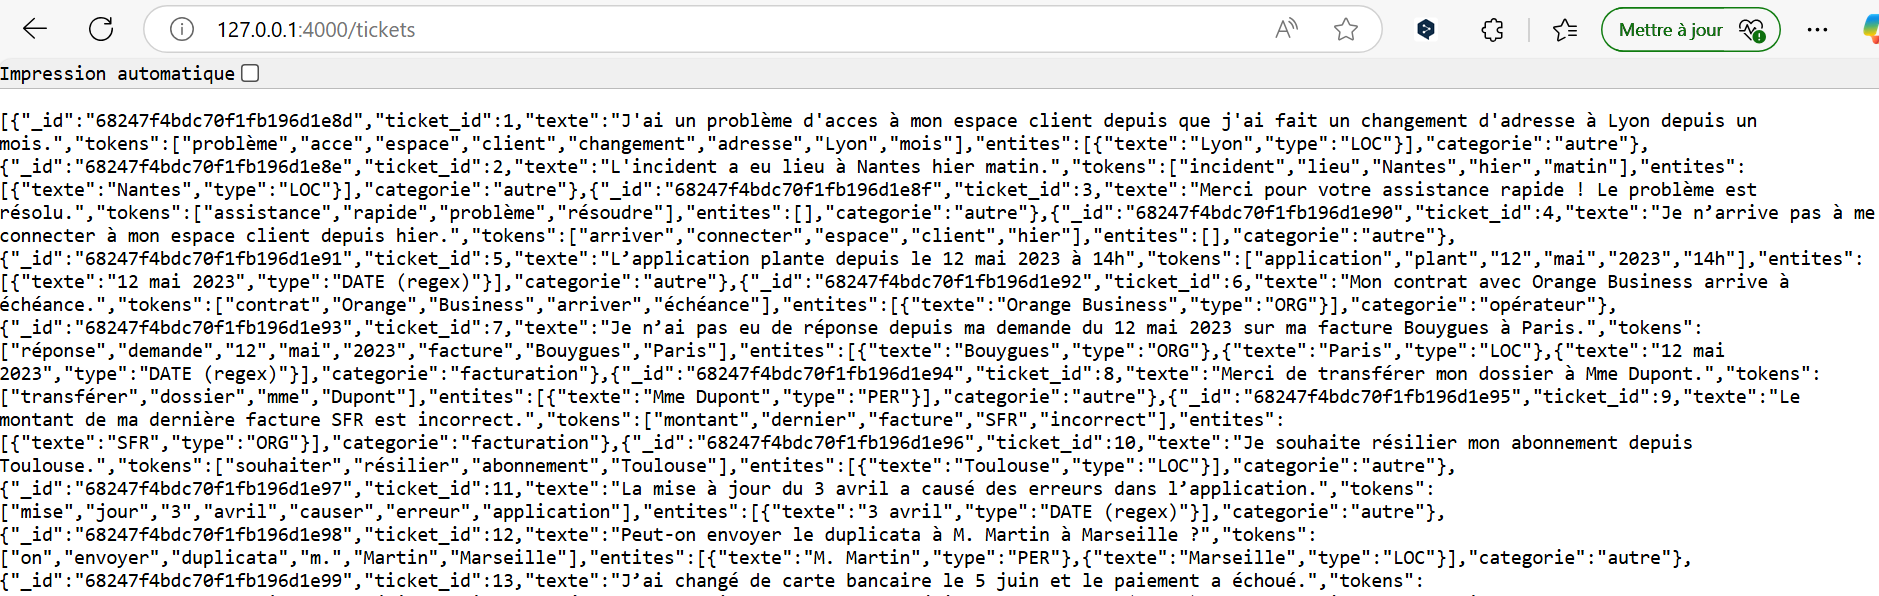

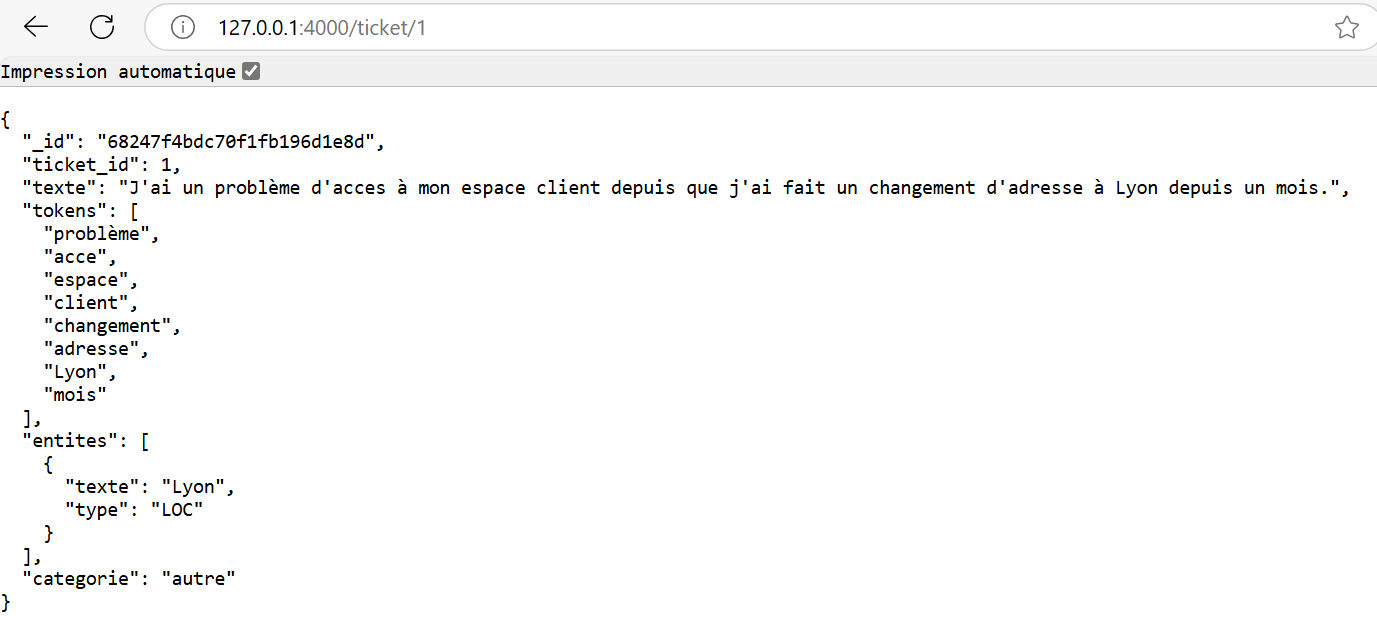

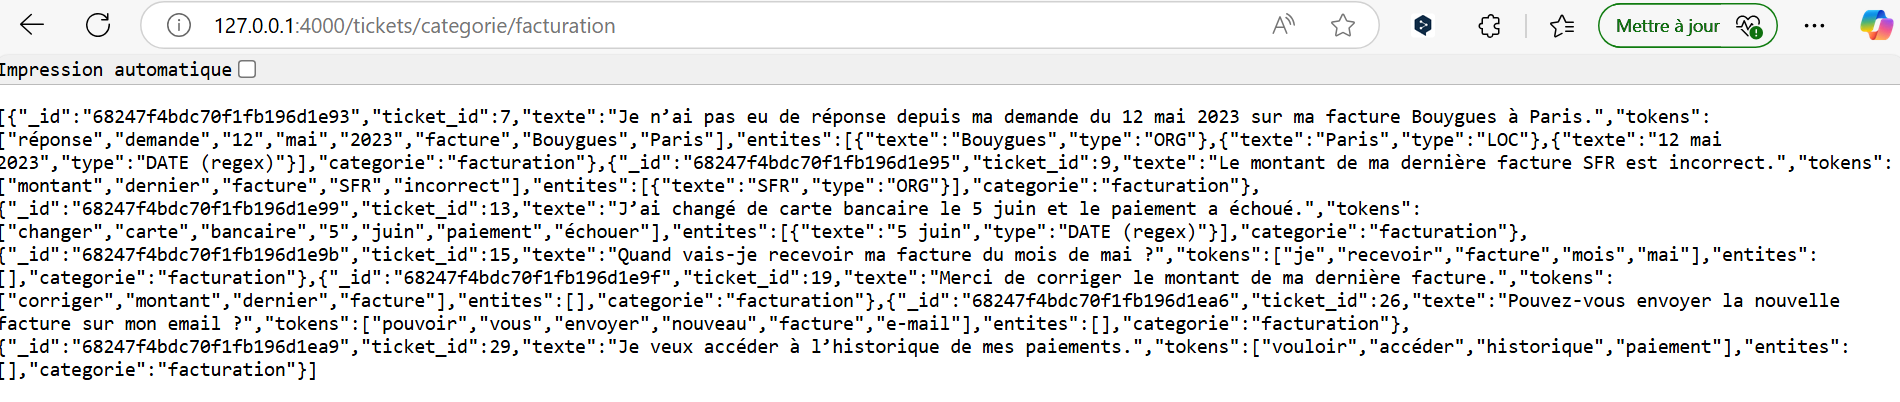

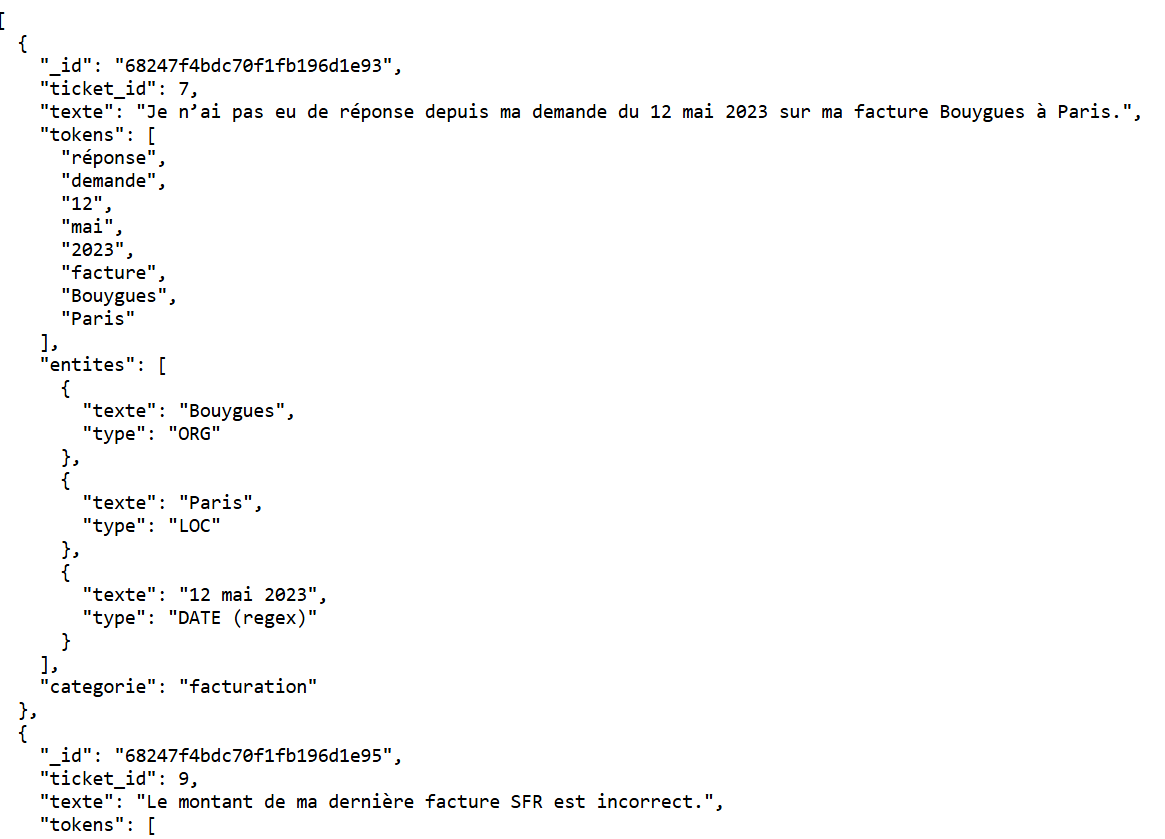

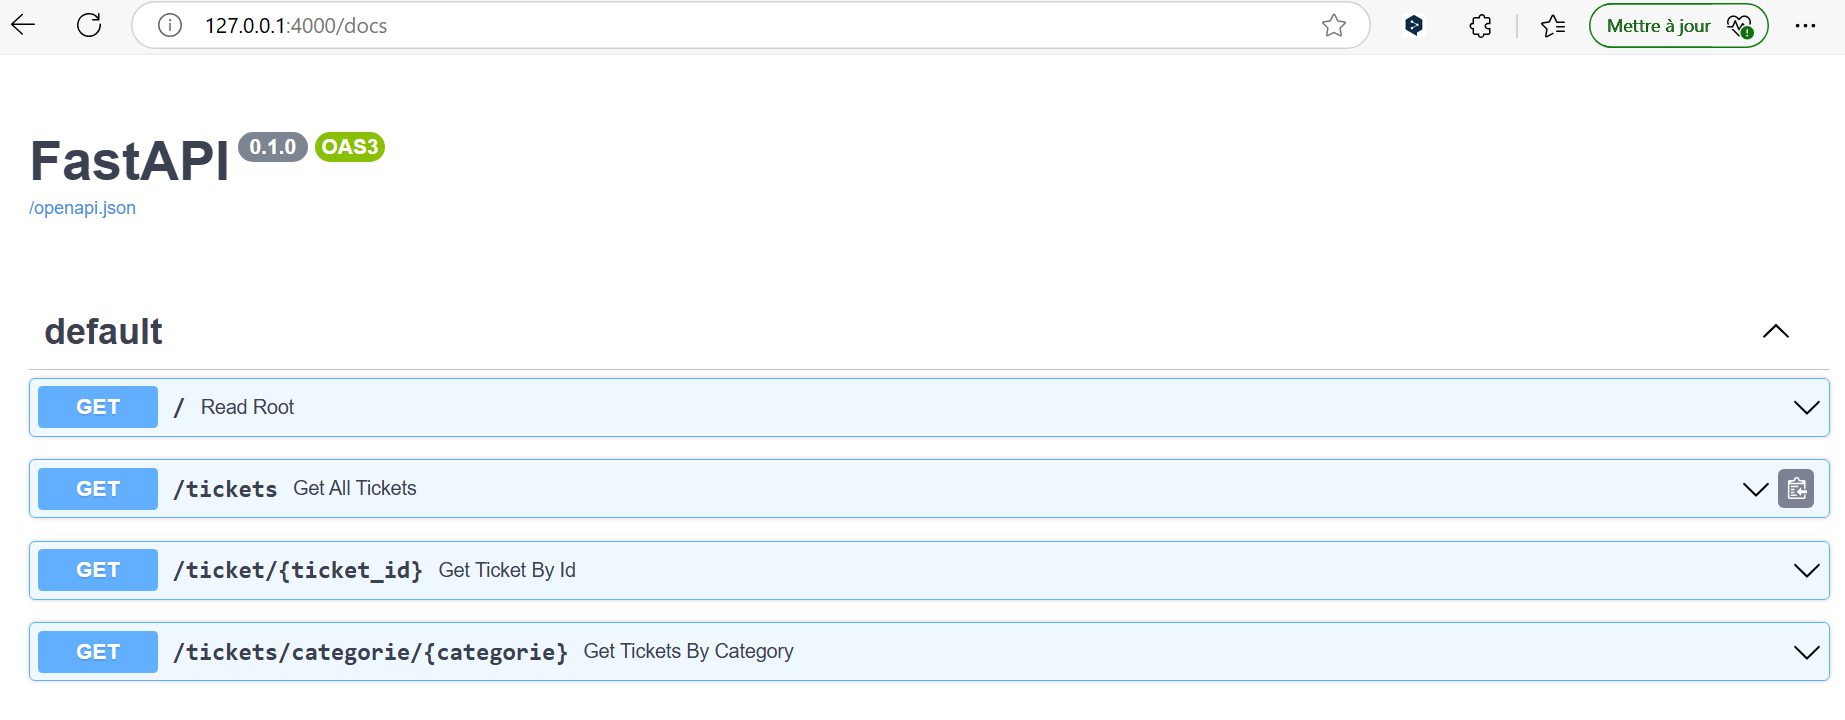

### Créer un script pour interagir avec l'utilisateur :



In [40]:
import spacy
from pymongo import MongoClient


C:\Users\manel\miniconda3\lib\site-packages\thinc\compat.py:36: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  hasattr(torch, "has_mps")
C:\Users\manel\miniconda3\lib\site-packages\thinc\compat.py:37: UserWarning: 'has_mps' is deprecated, please use 'torch.backends.mps.is_built()'
  and torch.has_mps  # type: ignore[attr-defined]


In [41]:
# Chargement du modèle spaCy
nlp = spacy.load("fr_core_news_sm")


# Connexion à la base de données MongoDB
client = MongoClient("mongodb://localhost:27017/")
db = client["support"]
tickets = db["tickets"]

# Traitement des documents
for doc in collection.find():
    texte = doc["texte"]
    doc_spacy = nlp(texte)
    entites = [{"texte": ent.text, "type": ent.label_} for ent in doc_spacy.ents]
    collection.update_one({"_id": doc["_id"]}, {"$set": {"entites": entites}})

In [45]:
   
def rechercher_ticket_par_id(ticket_id):
    ticket = collection.find_one({"ticket_id": ticket_id})
    return ticket

def rechercher_tickets_par_entite(entite_texte):
    # Recherche de tickets contenant l'entité spécifiée
    tickets = collection.find({"entites.texte": entite_texte})
    return list(tickets)

def chatbot():
    print("Bonjour ! Posez votre question concernant un ticket (tapez 'exit' pour quitter).")
    while True:
        question = input("Votre question : ")
        if question.lower() == 'exit':
            print("Au revoir !")
            break
        elif question.isdigit():
            # Recherche par identifiant de ticket
            ticket_id = int(question)
            ticket = rechercher_ticket_par_id(ticket_id)
            if ticket:
                print(f"Ticket trouvé :\nID: {ticket['ticket_id']}\nTexte: {ticket['texte']}")
            else:
                print("Aucun ticket trouvé avec cet identifiant.")
        else:
            # Analyse de la question pour extraire les entités
            doc = nlp(question)
            entites = [ent.text for ent in doc.ents if ent.label_ in ['LOC', 'GPE']]
            if entites:
                for entite in entites:
                    tickets = rechercher_tickets_par_entite(entite)
                    if tickets:
                        print(f"Tickets mentionnant '{entite}':")
                        for ticket in tickets:
                            print(f"- ID: {ticket['ticket_id']}, Texte: {ticket['texte']}")
                    else:
                        print(f"Aucun ticket trouvé mentionnant '{entite}'.")
            else:
                print("Aucune entité pertinente trouvée dans votre question.")

if __name__ == "__main__":
    chatbot()


Bonjour ! Posez votre question concernant un ticket (tapez 'exit' pour quitter).
Votre question : 2
Ticket trouvé :
ID: 2
Texte: L'incident a eu lieu à Nantes hier matin.
Votre question : Quels sont les tickets concernant Lyon ?
Tickets mentionnant 'Lyon':
- ID: 1, Texte: J'ai un problème d'acces à mon espace client depuis que j'ai fait un changement d'adresse à Lyon depuis un mois.


KeyboardInterrupt: Interrupted by user

### A vous mnt!

* Recherche par identifiant de ticket
* Quels sont les tickets concernant Lyon ?
* Montre-moi les tickets du 12 mai 2023.
* Quels sont les tickets liés à la facturation ?
